In [73]:
import logging
import numpy as np
from docplex.mp.model_reader import ModelReader
import math
import numpy as np
from docplex.mp.basic import Expr
from docplex.mp.model import Model
from docplex.mp.solution import SolveSolution
from docplex.util.status import JobSolveStatus
import cplex.callbacks as cpx_cb
from docplex.mp.relax_linear import LinearRelaxer



# Convertng an quadratic non-convex constraint to a linear constraint

Generally speaking, if $u$ and $p$ are variables in a mathematical program, and you want to deal with their product $z= xy$ you will end up having a quadratic problem (which may create problems with convexity if the quadratic terms appear in constraints). There is a special case, though, when at least one of  $u$ and $p$ is binary, and when the other variable is bounded. Under those assumptions, the product can be linearized.

Let $u$ be binary and let $L ≤ p ≤ M$ where $L$ and $M$ are bounds known in advance. Introduce a new variable $z$. (Programming note: Regardless of whether $p$ is real-valued, integer-valued or binary, $z$ can be treated as real-valued.) Add the following four constraints:

### $z ≤ Mu$  ... (1)

### $z ≥ Lu$ ... (2)

### $z ≤ p−L(1−u)$ ... (3)

### $z ≥ p − M(1−u)$ ... (4)

Consider the first case $u=0$, which means the product $z=uy$ should be zero. The first pair of inequalities says $0 ≤ y ≤ 0$, forcing $z=0$.The second pair of inequalities says $p-M ≤ z ≤ p-L$, and $z=0$ satisfies those inequalities.

Now consider the second case $u=1$, which means the product $z=y$ should be zero. The first pair of inequalities becomes $L ≤ p ≤ M$, , which is satisfied by $z=p$. The second pair says $p ≤ z ≤ p$, forcing $z=y$ as desired.

in our case u, p are both binary. Therefore M = 1 and L =0

### $z ≤ u$  ... (1)

### $z ≥ 0 $ ... (2)

### $z ≤ p$ ... (3)

### $z ≥ p +u −1$ ... (4)




In [74]:
from docplex.mp.model import Model
opt_model = Model(name="MIP Model")

Nc= 130 # Nc is the number of seconds

Dist=3000 # Distance to travel

tolerance = 2 # Tolerance in distance travelled

delta_v=1 # Rate of acceleration/deceleration set to 1

vmax=150 # Max speed of a TGV in France (in m/s)

alpha=0.05 # Regenerative braking efficiency

"""
We define two binary variables for two bits. 
When x=0 and y=0 then constant velocity
When x=1 and y=0 then acceleration
When x=0 and y=1 then breaking
"""

x={}
for i in range(0, Nc):
    x[i]= opt_model.binary_var(name=f"x_{i}")

y={}
for i in range(0, Nc):
    y[i]= opt_model.binary_var(name=f"y_{i}")

z={}
for i in range(0, Nc):
    z[i]= opt_model.binary_var(name=f"z_{i}")
    

objective = opt_model.linear_expr()
## objective is the hamiltonian/energy value we want to minimize
## Energy:
for i in range(0, Nc):
    objective += (delta_v**2) * x[i] - alpha*(delta_v**2)*y[i]
    #objective += (delta_v**2)*x[i]

    
opt_model.minimize(objective)

    
## Constraint 1: (simultaneous braking/acceleration)
"""
Constraint 1: (simultaneous braking/acceleration for each time slice)
which means 
for i in range(0, Nc):
    opt_model.add_constraint(x[i] * y[i] == 0 ) 
This will lead to quadratic non-convex constraint. So We linearize it with the above prescription

"""
# opt_model.add_constraint(opt_model.sum(x[i] * y[i] for i in range(1, Nc)) == 0 , "No_simultaneous_braking_or_acceleration_constraint")

for i in range(0, Nc):
    opt_model.add_constraint(z[i] <= x[i] , f"z_u_d_{i}") 

for i in range(0, Nc):
    opt_model.add_constraint(z[i] <= y[i], f"z_p_d_{i}")
        
for i in range(0, Nc):
    opt_model.add_constraint(z[i] >= x[i]+ y[i] -1 , f"z_u_p_d_{i}") 
    
opt_model.add_constraint(opt_model.sum(z[i] for i in range(0, Nc)) == 0 , "No_simultaneous_braking_or_acceleration_constraint")

### This is another way to write the No simultaneous braking or acceleration constraint also
# for i in range(0, Nc):
#     opt_model.add_constraint(z[i] == 0 , f"z_u_p_d_0{i}") 


"""
Constraint 2: (Total Distance constraints)
"""

distance = opt_model.linear_expr()
velocity = 0
for i in range(0, Nc):
    velocity = velocity + delta_v*(x[i]-y[i])
    distance += velocity
opt_model.add_constraint(distance <= Dist+tolerance, "Max_Distance_constraint")
opt_model.add_constraint(distance >= Dist-tolerance, "Min_Distance_constraint")

### old distance constraints for conparison
# opt_model.add_constraint(opt_model.sum(((Nc-i)*delta_v*y[i]-(Nc-i)*delta_v*x[i]) for i in range(0, Nc)) == Dist , "Distance constraint")
# opt_model.add_constraint(opt_model.sum((i*delta_v*y[i]+i*delta_v*x[i]+ ) for i in range(0, Nc)) == Dist , "Distance constraint")

"""
Constraint 3: (Net-Zero contraint)

"""
opt_model.add_constraint(opt_model.sum((y[i]-x[i]) for i in range(0, Nc)) == 0 , "Net_Zero_constraint")

"""
Constraint 4: (Maximum Speed)

"""
opt_model.add_constraint(opt_model.sum((delta_v*x[i]) for i in range(0, Nc)) <= vmax , "Maximum_Speed_constraint")

#Constraint 5: (Positive Speed)
for i in range(Nc):
    opt_model.add_constraint(opt_model.sum((x[i]-y[i]) for i in range(0, i)) >= 0 , "Positive_Speed_constraint")

#Constraint 6: (Must leave immediately)

opt_model.add_constraint(x[0]==1, "Must leave immediately constraint")
    

#### Print the optimization model

opt_model.print_information() 

print(opt_model.prettyprint())               


Model: MIP Model
 - number of variables: 390
   - binary=390, integer=0, continuous=0
 - number of constraints: 526
   - linear=526
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
// This file has been generated by DOcplex
// model name is: MIP Model
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;
dvar bool x_9;
dvar bool x_10;
dvar bool x_11;
dvar bool x_12;
dvar bool x_13;
dvar bool x_14;
dvar bool x_15;
dvar bool x_16;
dvar bool x_17;
dvar bool x_18;
dvar bool x_19;
dvar bool x_20;
dvar bool x_21;
dvar bool x_22;
dvar bool x_23;
dvar bool x_24;
dvar bool x_25;
dvar bool x_26;
dvar bool x_27;
dvar bool x_28;
dvar bool x_29;
dvar bool x_30;
dvar bool x_31;
dvar bool x_32;
dvar bool x_33;
dvar bool x_34;
dvar bool x_35;
dvar bool x_36;
dvar bool x_37;
dvar bool x_38;
dvar bool x_39;
dvar bool x_40;
dvar bool x_41;
dvar bool x_42;
dvar bool x_43;
dvar boo

In [75]:
result = opt_model.solve(log_output=True) #(log_output=self.solver_config.cplex_log)
x_value=[]
for l in range(0, Nc):
    x_value.append(result.get_value(f"x_{l}"))
    print(f"x_{l} =" , result.get_value(f"x_{l}")  )

y_value=[]
for l in range(0, Nc):
    y_value.append(result.get_value(f"y_{l}"))
    print(f"y_{l} =" , result.get_value(f"y_{l}")  )
    

print("Binary Variables X" , x_value, "Binary Variables y" , y_value, "Objective value", result.objective_value )


Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 267 rows and 132 columns.
MIP Presolve modified 518 coefficients.
Reduced MIP has 259 rows, 258 columns, and 17536 nonzeros.
Reduced MIP has 258 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (11.56 ticks)
Probing time = 0.00 sec. (0.45 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 259 rows, 258 columns, and 17536 nonzeros.
Reduced MIP has 258 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.32 ticks)
Probing time = 0.00 sec. (0.45 ticks)
Clique table members: 130.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.00 sec. (4.29 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best 

## Visualisation of results

In [76]:
def distance(x, y, Nc):
    velocity = 0
    vel = [0]
    dist = [0]
    dist_tot= 0
    for i in range(0, Nc):
        velocity = velocity + delta_v*(x[i]-y[i])
        vel.append(velocity)
        dist_tot += velocity
        dist.append(dist_tot)
    return dist,vel

In [77]:
time= np.arange(Nc+1)
distn, velo = distance(x_value, y_value, Nc)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


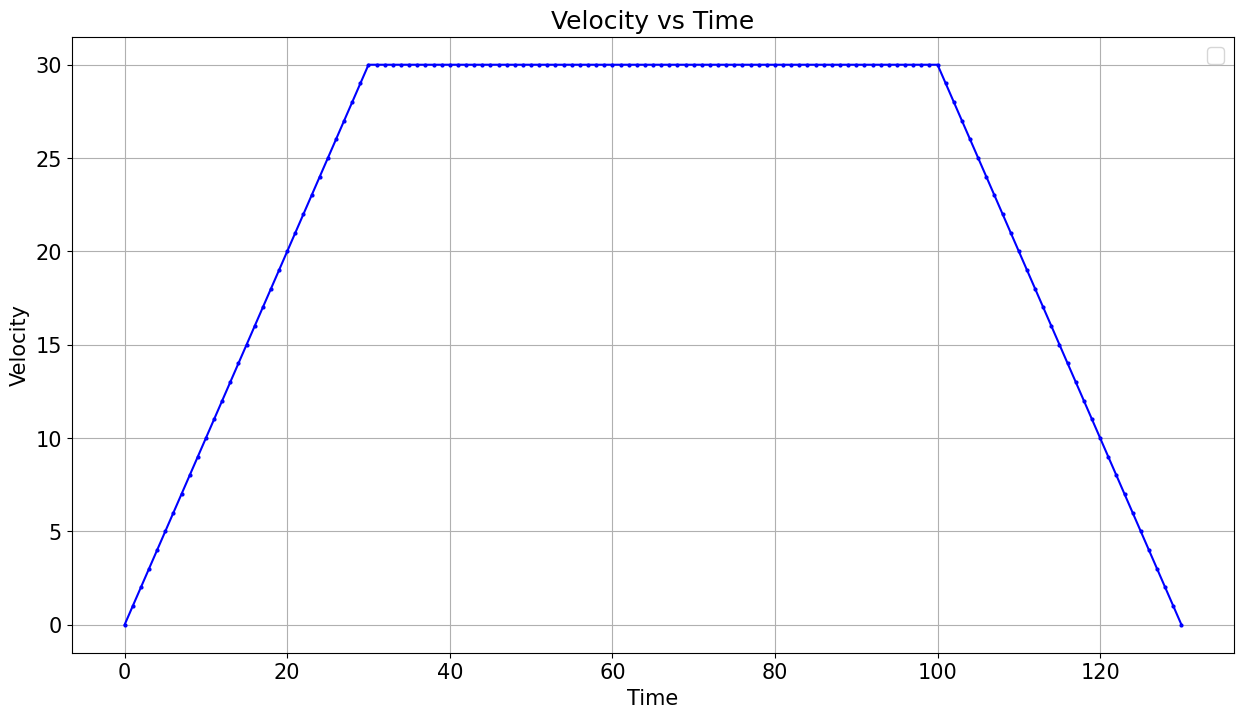

22.900763358778626


In [78]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

matplotlib.rcParams.update({"font.size": 15})

# plt.step(time, velo, c='b', marker="o", markersize=1, linestyle='-')#, label='label') 
plt.plot(time, velo, c='b', marker="o", markersize=2, linestyle='-')#, label='label)

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title("Velocity vs Time")
plt.grid(axis='x')
plt.grid(axis='y')
plt.legend()
plt.show()
print(np.average(velo))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


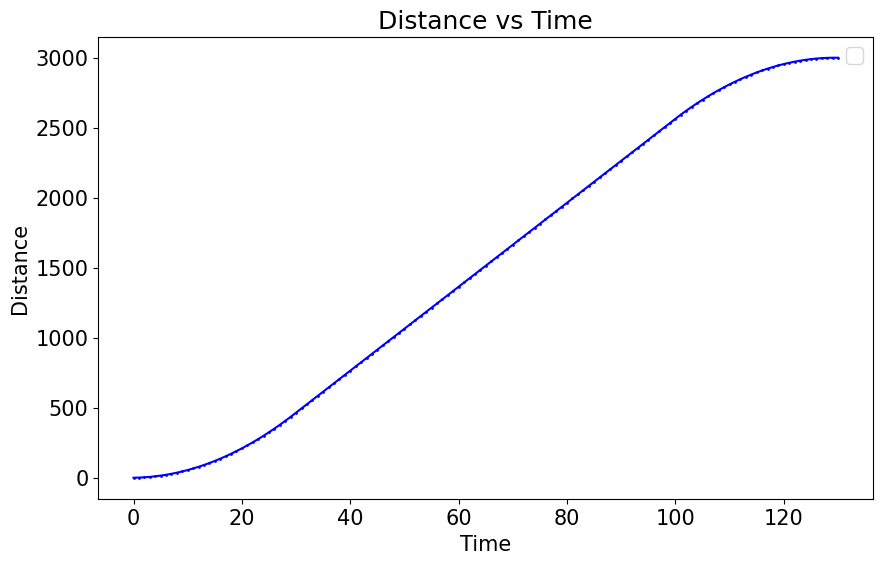

In [79]:
import matplotlib
plt.figure(figsize=(10,6))

matplotlib.rcParams.update({"font.size": 15})

plt.plot(time, distn, c='b', marker="o", markersize=1, linestyle='-')#, label='label')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.title("Distance vs Time")
plt.legend()
plt.show()